<a href="https://colab.research.google.com/github/jeawonlll/KOHI2022_tutorials/blob/main/20220820/KOHI_MIMIC_Data_Modeling_210821_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MIMIC-III데이터 실습 관련 코드입니다
###실습진행 순서
1. 환자 프로파일 만들기
2. 환자 데이터 추출하기
3. Missing Data처리
4. 데이터 Normalize하기
5. 학습, 검증, 테스트 데이터로 나누기
6. LR모델 학습
7. XGB모델 학습
8. NN모델 학습
9. 결과 시각화 하기




###필요한 데이터들 다운 받기
1. 아래의 코드 블럭 실행
2. 실행 후 나오는 링크를 클릭

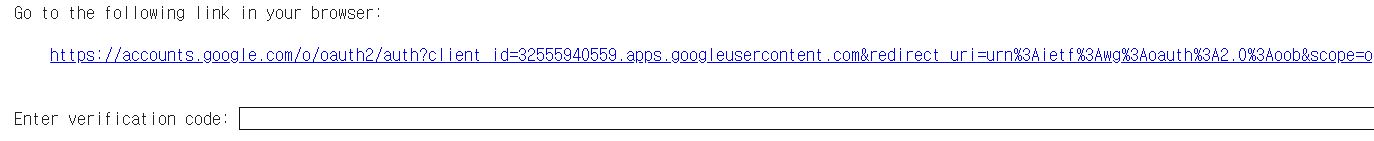
3. 로그인

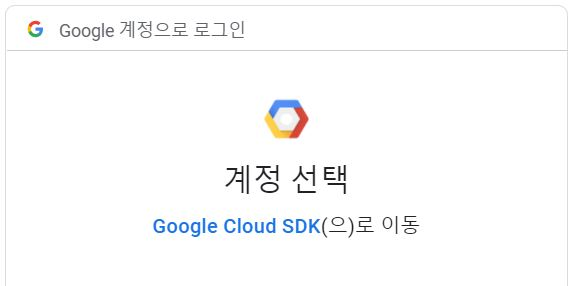
4. 허용 클릭

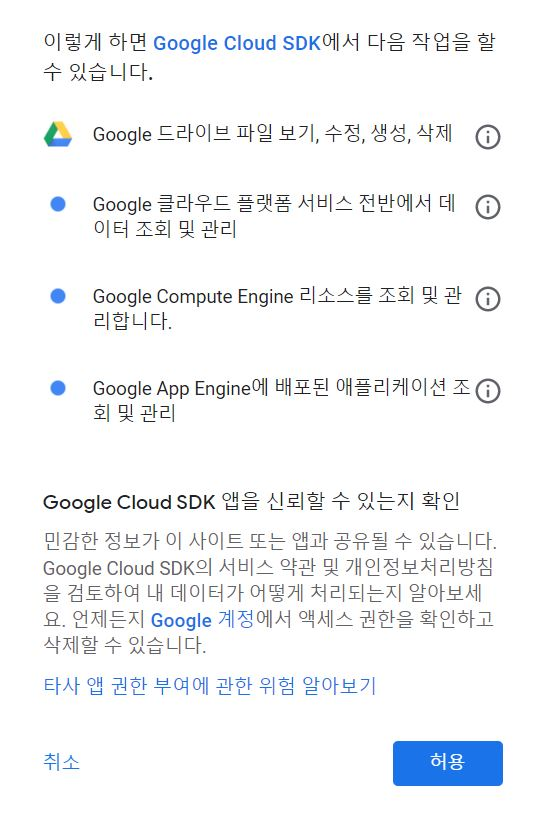
5. 코드 복사

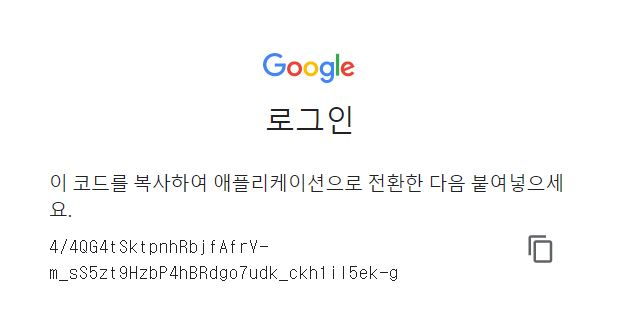
5. 코드 복사

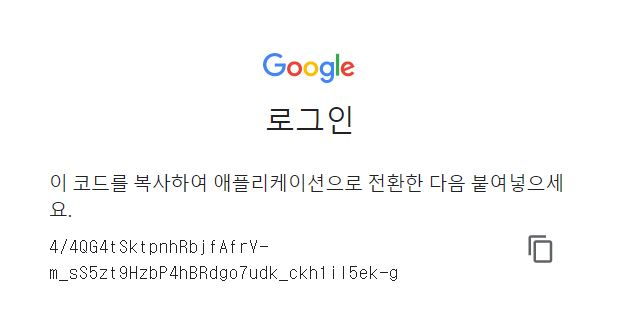


In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
FILE_IDS = ["1-91Ad_3yQQ0T6ROnlxqbbgEFc6tiZAsY",
            "1-RbUxW2hF2ayWDhkMqGfKZvzEKwiLqQX",
            "1r76_XuYikaeswLAIpIbPpkx_kXgJob3a",
            "1-I25PxwI6qpDrNtDJD_jEnLl_MXh9hjH",
            "1-3YZEp8xFYplMjvFSfzb637WwA8OwW_2",
            "1-HhOwcDMse4BevovRkxOBICe5zZ3YraZ",
            "1GO4MIIzgNOB8zDvtgldU5JdLZbMlnczz"]
FILE_NAMES = ['PATIENTS.csv', 'LABEVENTS.csv', 'CHARTEVENTS.csv',
              'D_ITEMS.csv', 'D_LABITEMS.csv', 'ADMISSIONS.csv', 'ICUSTAYS.csv']
for f_id, f_name in tqdm(zip(FILE_IDS, FILE_NAMES), desc="Download Files...", total=len(FILE_IDS), ncols=75):
  download_file = drive.CreateFile({'id': f_id})
  download_file.GetContentFile(f_name)

Download Files...: 100%|█████████████████████| 7/7 [00:24<00:00,  3.56s/it]


In [3]:
import os
import csv
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

#Get HADM_ID
admissions = pd.read_csv('ADMISSIONS.csv')
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
HADM_ID = admissions['HADM_ID'].to_numpy()
print(len(HADM_ID))

admissions['ADMITTIME']



1262


0      2136-04-03 18:35:00
1      2150-06-24 23:31:00
2      2191-02-25 20:30:00
3      2107-09-05 14:58:00
4      2154-03-30 14:59:00
               ...        
1257   2187-08-20 20:46:00
1258   2111-04-13 02:14:00
1259   2180-03-27 04:17:00
1260   2194-10-09 13:19:00
1261   2195-09-08 22:31:00
Name: ADMITTIME, Length: 1262, dtype: datetime64[ns]

In [4]:
#Get ICUSTAYS
icustays = pd.read_csv('ICUSTAYS.csv')
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
print(icustays.columns)
icustays[['INTIME', 'OUTTIME']]

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object')


,INTIME,OUTTIME
0,2150-06-24 23:36:18,2150-06-25 20:56:47
1,2191-02-25 21:09:05,2191-04-25 15:38:56
2,2107-09-08 11:40:19,2107-09-23 17:56:41
3,2185-01-07 01:04:00,2185-01-10 12:59:00
4,2162-04-10 05:06:04,2162-04-10 07:40:17
...,...,...
1304,2134-05-21 23:01:28,2134-05-22 08:29:05
1305,2165-11-07 10:56:01,2165-11-08 15:22:35
1306,2140-12-25 11:36:53,2141-01-01 18:19:17
1307,2141-01-19 16:47:54,2141-02-07 18:47:37


In [5]:
#Read Chartevents
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)
chartevents['CHARTTIME'] = pd.to_datetime(chartevents['CHARTTIME'])


#Read Labevents
labevents = pd.read_csv('LABEVENTS.csv', low_memory=False)
labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])

In [6]:
VITAL_SIGNS = {'PULSE': [220045, 211],
               'RESP': [220210, 618],
               'TEMP_C': [223762, 676, 677],
               'TEMP_F': [223761, 678, 679],
               'SBP': [220050, 220179, 225309, 51, 455],
               'DBP': [220051, 220180, 225310, 8368, 8441],
               'FiO2': [223835, 189, 190],
               'GCS_EYE': [220739],
               'GCS_MOT': [223901],
               'GCS_VER': [223900],
               'GCS_TOTAL': [198]
               }
LABS = {'BILIRUBIN': [50885],
        'LACTATE': [50813],
        'pH': [50820, 50831],
        'SODIUM': [50983],
        'POTASSIUM': [50971],
        'CREATININE': [50912],
        'WBC': [51301],
        'HEMATOCRIT': [51221]
        }

##환자 프로파일 만들기

##프로파일
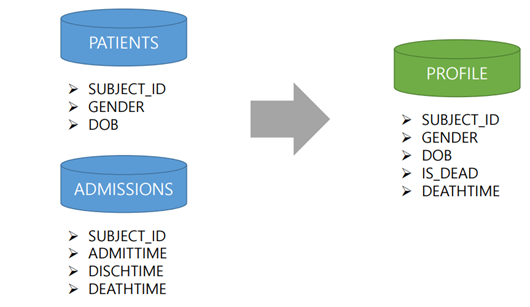

In [7]:
#필요한 패키지들 import하기
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#Mortality
#프로파일 만들기
import os
import csv
import pickle as pkl
from datetime import datetime
from sklearn.utils import shuffle

#Make Profiles directory
if not os.path.exists('Profiles'):
  os.mkdir('Profiles')

#Read Patients File
reader = csv.DictReader(open('PATIENTS.csv', 'r'))
patient_dic = dict()
for row in reader:
  patient_dic[row['SUBJECT_ID']] = row

#Read Admission File
reader = csv.DictReader(open('ADMISSIONS.csv', 'r'))
adm_dic = dict()
for row in reader:
  adm_dic[row['HADM_ID']] = row

#Make HADM_ID List
HADMS = list(adm_dic.keys())


In [9]:
#Function of making profiles
def make_profile(profile_dic, subject_id, hadm_id, gender, adm_time, dob, is_dead, dod):
  profile_list = profile_dic.get(subject_id, list())
  profile_list.append({'HADM_ID': hadm_id, 'GENDER': gender, 'DOB': dob, 'ADM_TIME': adm_time, 'IS_DEAD': is_dead, 'DOD': dod})
  profile_dic[subject_id] = profile_list
  return profile_dic


In [10]:
profile_dic = dict()
for hadm_id in HADMS:
  subject_id = adm_dic[hadm_id]['SUBJECT_ID'] #Get subject id from admissions with hadm_id
  is_dead = int(adm_dic[hadm_id]['HOSPITAL_EXPIRE_FLAG']) #Get label (HOSPITAL_EXPIRE_FLAG) for mortality from admission with hadm_id
  #Convert string type data to datetime data
  adm_time = datetime.strptime(adm_dic[hadm_id]['ADMITTIME'], "%Y-%m-%d %H:%M:%S") #Get admission time
  if is_dead:
    dod = datetime.strptime(adm_dic[hadm_id]['DEATHTIME'], "%Y-%m-%d %H:%M:%S") #If patient died, get the dod from admissions
  else:
    dod = None
  gender = patient_dic[subject_id]['GENDER'] #Get gender from patients
  dob = datetime.strptime(patient_dic[subject_id]['DOB'], "%Y-%m-%d %H:%M:%S") #Get dob from patients
  profile_dic = make_profile(profile_dic, subject_id, hadm_id, gender, adm_time, dob, is_dead, dod) #Make profile dictionary

In [11]:
profile_dic

{'55': [{'HADM_ID': '190665',
   'GENDER': 'F',
   'DOB': datetime.datetime(2072, 2, 4, 0, 0),
   'ADM_TIME': datetime.datetime(2136, 4, 3, 18, 35),
   'IS_DEAD': 0,
   'DOD': None}],
 '82': [{'HADM_ID': '110641',
   'GENDER': 'M',
   'DOB': datetime.datetime(2150, 6, 24, 0, 0),
   'ADM_TIME': datetime.datetime(2150, 6, 24, 23, 31),
   'IS_DEAD': 0,
   'DOD': None}],
 '87': [{'HADM_ID': '190659',
   'GENDER': 'M',
   'DOB': datetime.datetime(2191, 2, 25, 0, 0),
   'ADM_TIME': datetime.datetime(2191, 2, 25, 20, 30),
   'IS_DEAD': 0,
   'DOD': None}],
 '148': [{'HADM_ID': '199488',
   'GENDER': 'F',
   'DOB': datetime.datetime(2029, 7, 11, 0, 0),
   'ADM_TIME': datetime.datetime(2107, 9, 5, 14, 58),
   'IS_DEAD': 0,
   'DOD': None}],
 '505': [{'HADM_ID': '116719',
   'GENDER': 'M',
   'DOB': datetime.datetime(2097, 11, 23, 0, 0),
   'ADM_TIME': datetime.datetime(2154, 3, 30, 14, 59),
   'IS_DEAD': 0,
   'DOD': None},
  {'HADM_ID': '103194',
   'GENDER': 'M',
   'DOB': datetime.datetime(2

In [12]:
with open('Profiles/profiles.pkl', 'wb') as fp:
  pkl.dump(profile_dic, fp) #Save profile dictionary into file


##재입실 예측 모델 학습을 위한 데이터 레이블링

재입실 양성 기준: ICU 퇴실 후 20일내 ICU 재입실 (임의로 정의) 

In [13]:
#HADM_ID 기준으로 ICU 입실 퇴실 그룹화 하기
in_out_times = icustays[['HADM_ID', 'INTIME', 'OUTTIME']]
print(len(in_out_times))
print(len(in_out_times['HADM_ID'].unique()))
in_out_groups = dict()
for index, row in in_out_times.iterrows():
  hadm_id = row['HADM_ID']
  intime = row['INTIME']
  outtime = row['OUTTIME']
  in_out_groups[hadm_id] = in_out_groups.get(hadm_id, list())
  in_out_groups[hadm_id].append((intime, outtime))

1309
1232


In [14]:
#재입실 기록이 있는 환자들 찾기
readmin_y = dict()
for kk, vv in in_out_groups.items():
  if len(vv) > 1:
    readmin_y[kk] = vv

In [15]:
#재입실이 20일이내인 환자들 찾기
readmin_20days_y = dict()
for kk, vv in readmin_y.items():
  for i in range(1, len(vv)):
    org_out = vv[i-1][1]
    re_in = vv[i][0]
    time_gap = (re_in - org_out)
    if time_gap.days <= 20:
      readmin_20days_y[kk] = (True, org_out)
      break

     HADM_ID READMISSION_YN
0     190665              0
1     110641              0
2     190659              0
3     199488              0
4     116719              0
...      ...            ...
1257  176834              0
1258  172532              0
1259  187979              0
1260  109643              0
1261  166893              0

[1262 rows x 2 columns]


Text(0, 0.5, '')

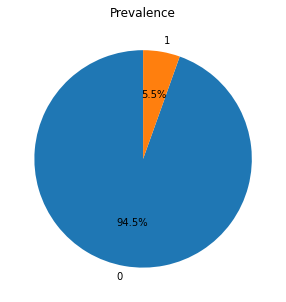

In [16]:
#재입실 레이블 만들기
readmission_yn = pd.DataFrame(columns = ['HADM_ID', 'READMISSION_YN'])
for hadm_id in HADM_ID:
  if hadm_id in readmin_20days_y:
    readmission_yn = readmission_yn.append({'HADM_ID': hadm_id, 'READMISSION_YN': 1}, ignore_index=True)
  else:
    readmission_yn = readmission_yn.append({'HADM_ID': hadm_id, 'READMISSION_YN': 0}, ignore_index=True)

print(readmission_yn)

fig = plt.figure(figsize=(5,5))
readmission_yn.READMISSION_YN.value_counts().plot.pie(startangle = 90, autopct='%1.1f%%')
plt.title('Prevalence')
plt.ylabel('')

##Medical Score계산 해보기
##APACHE-2 Score
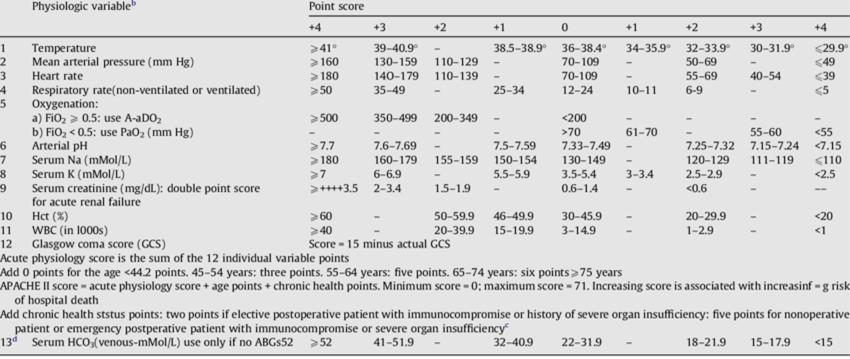

In [17]:
import os
import csv
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

#Get HADM_ID
admissions = pd.read_csv('ADMISSIONS.csv')
###입실 시점의 데이터를 Datetime 형태로 수정
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'], format = '%Y-%m-%d %H:%M:%S')
HADM_ID = admissions['HADM_ID'].to_numpy()
HADM_ID



array([190665, 110641, 190659, ..., 187979, 109643, 166893])

In [18]:
#Read Chartevents
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)
###데이터 입력 시점의 데이터를 Datetime 형태로 수정
chartevents['CHARTTIME'] = pd.to_datetime(chartevents['CHARTTIME'], format = '%Y-%m-%d %H:%M:%S')

#Read Labevents
###데이터 입력 시점의 데이터를 Datetime 형태로 수정
labevents = pd.read_csv('LABEVENTS.csv', low_memory=False)
labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'], format = '%Y-%m-%d %H:%M:%S')

In [19]:
VITAL_SIGNS = {'PULSE': [220045, 211],
               'RESP': [220210, 618],
               'TEMP_C': [223762, 676, 677],
               'TEMP_F': [223761, 678, 679],
               'SBP': [220050, 220179, 225309, 51, 455],
               'DBP': [220051, 220180, 225310, 8368, 8441],
               'FiO2': [223835, 189, 190],
               'GCS_EYE': [220739],
               'GCS_MOT': [223901],
               'GCS_VER': [223900],
               'GCS_TOTAL': [198]
               }
LABS = {'BILIRUBIN': [50885],
        'LACTATE': [50813],
        'pH': [50820, 50831],
        'SODIUM': [50983],
        'POTASSIUM': [50971],
        'CREATININE': [50912],
        'WBC': [51301],
        'HEMATOCRIT': [51221]
        }

In [20]:
Normal_Values = {
        'PULSE': 80,
        'RESP': 17,
        'TEMP_C': 37,
        'TEMP_F': 98,
        'MBP': 85,
        'FiO2': 0,
        'BILIRUBIN': 0.6,
        'LACTATE': 0.7,
        'pH': 7.4,
        'SODIUM': 140,
        'POTASSIUM': 4.2,
        'CREATININE': 0.8,
        'WBC': 7,
        'HEMATOCRIT': 45,
        'GCS': 15
}

In [21]:
APACHE_CODES = ['PULSE',
        'RESP',
        'TEMP',
        'MBP',
        'FiO2',
        'pH',
        'SODIUM',
        'POTASSIUM',
        'CREATININE',
        'WBC',
        'HEMATOCRIT',
        'GCS']

In [22]:
def get_features_by_hadmid(chartevents, labevents, hadm_id, vs_codes, lab_codes):
  vs = dict()
  lab = dict()
  for kk in vs_codes.keys():
    #Get Vital Sign features from chartevents with hadm_id and itemid
    vs[kk] = chartevents.loc[(chartevents['HADM_ID'] == hadm_id) & (chartevents['ITEMID'].isin(vs_codes[kk]))]
  for kk in lab_codes.keys():
    #Get Lab test features from labevents with hadm_in adn itemid
    lab[kk] = labevents.loc[(labevents['HADM_ID'] == hadm_id) & (labevents['ITEMID'].isin(lab_codes[kk]))]
  
  return vs, lab

In [23]:
def reform_data(datas):
  #Extract values of features and Refrom dataframe types to numpy array
  reform_data = dict()
  for kk in datas.keys():
    values = datas[kk]['VALUENUM'].to_numpy()
    reform_data[kk] = values
    
  return reform_data

    

In [24]:
def get_worst_value(worst_values, features, is_vs=False):
  for kk in features.keys():
    if not kk in ['GCS_TOTAL', 'GCS_EYE', 'GCS_MOT', 'GCS_VER', 'SBP', 'DBP', 'TEMP_F', 'TEMP_C']:
      if len(features[kk]) > 0:
        worst_values[kk] = np.min(features[kk])
    elif kk == 'TEMP_F':
      worst_values['TEMP'] = np.min(((features[kk] - 32) / 1.8)) #Convert F to C
    elif kk == 'TEMP_C':
      worst_values['TEMP'] = np.min(features[kk])
  
  if is_vs:
    if len(features['GCS_TOTAL']) > 0:
      worst_values['GCS'] = np.min(features['GCS_TOTAL'])
    elif len(features['GCS_EYE']) > 0:
      worst_values['GCS'] = np.min(features['GCS_EYE'] + features['GCS_MOT'] + features['GCS_VER'])

    if len(features['SBP']) > 0 and len(features['DBP'] > 0):
      worst_values['MBP'] = (np.min(features['SBP']) + 2 * np.min(features['DBP'])) / 3.
  
  return worst_values

def get_normal_values(worst_values):
  for kk in APACHE_CODES:
    if kk not in worst_values:
      worst_values[kk] = Normal_Values[kk]
  return worst_values

In [25]:
def calc_apache(chartevents, labevents, hadm_id):
  vs, lab = get_features_by_hadmid(chartevents, labevents, hadm_id, VITAL_SIGNS, LABS)

  vs = reform_data(vs)
  lab = reform_data(lab)  

  worst_values = dict()
  get_worst_value(worst_values, vs, is_vs=True)
  get_worst_value(worst_values, lab, is_vs=False)
  worst_values = get_normal_values(worst_values)

  total_scores = 0
  for kk in APACHE_CODES:
    if kk == 'TEMP':
      if worst_values[kk] < 30:
        total_scores += 4
      elif worst_values[kk] < 32:
        total_scores += 3
      elif worst_values[kk] < 34:
        total_scores += 2
      elif worst_values[kk] < 36:
        total_scores += 1
      else:
        total_scores += 0
  
    elif kk == 'CREATININE':
      if worst_values[kk] < 0.6:
        total_scores += 4
      elif worst_values[kk] < 0.6:
        total_scores += 2
      else:
        total_scores += 0
    
    elif kk == 'FiO2':
      if worst_values[kk] > 0.5:
        total_scores += 3
      else:
        total_scores +=0

    elif kk == 'GCS':
      total_scores += (15 - worst_values[kk])

    elif kk == 'HEMATOCRIT':
      if  worst_values[kk] < 20:
        total_scores += 4
      elif  worst_values[kk] < 30:
        total_scores += 2
      else:
        total_scores += 0

    elif kk == 'MBP':
      if worst_values[kk] < 50:
        total_scores += 4
      elif worst_values[kk] < 70:
        total_scores += 2
      else:
        total_scores += 0

    elif kk == 'POTASSIUM': 
      if worst_values[kk] < 2.5:
        total_scores += 4
      elif worst_values[kk] < 3:
        total_scores += 2
      elif worst_values[kk] < 3.5:
        total_scores += 1
      else:
        total_scores += 0

    elif kk == 'PULSE': 
      if worst_values[kk] < 40:
        total_scores += 4
      elif worst_values[kk] < 55:
        total_scores += 3
      elif worst_values[kk] < 70:
        total_scores += 2
      else:
        total_scores += 0
    
    elif kk == 'RESP': 
      if worst_values[kk] < 6:
        total_scores += 4
      elif worst_values[kk] < 10:
        total_scores += 2
      elif worst_values[kk] < 12:
        total_scores += 1
      else:
        total_scores += 0
    
    elif kk == 'SODIUM': 
      if worst_values[kk] < 111:
        total_scores += 4
      elif worst_values[kk] < 120:
        total_scores += 3
      elif worst_values[kk] < 130:
        total_scores += 2
      else:
        total_scores += 0

    elif kk == 'WBC': 
      if worst_values[kk] < 1:
        total_scores += 4
      elif worst_values[kk] < 3:
        total_scores += 2
      else:
        total_scores += 0

    elif kk == 'pH':
      if worst_values[kk] < 7.15:
        total_scores += 4
      elif worst_values[kk] < 7.25:
        total_scores += 3
      elif worst_values[kk] < 7.33:
        total_scores += 2
      else:
        total_scores += 0

  return total_scores

In [26]:
print(calc_apache(chartevents, labevents, HADM_ID[205]))

29.0


##차후에 구현 해보면 좋을 것들
1. 몇가지 빠진 항목도 (Age, HCO3 등) 추가해보기
2. SOFA스코어도 구현해보기


In [27]:
import os
import csv
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

In [28]:
Normal_Values = {
        'PULSE': 80,
        'RESP': 17,
        'TEMP_C': 37,
        'TEMP': 37,
        'TEMP_F': 98,
        'MBP': 85,
        'FiO2': 0,
        'BILIRUBIN': 0.6,
        'LACTATE': 0.7,
        'pH': 7.4,
        'SODIUM': 140,
        'POTASSIUM': 4.2,
        'CREATININE': 0.8,
        'WBC': 7,
        'HEMATOCRIT': 45,
        'GCS': 15
}

In [29]:
APACHE_CODES = ['PULSE',
        'RESP',
        'TEMP',
        'MBP',
        'FiO2',
        'pH',
        'SODIUM',
        'POTASSIUM',
        'CREATININE',
        'WBC',
        'HEMATOCRIT',
        'GCS']

In [30]:
def get_features_by_hadmid(chartevents, labevents, hadm_id, vs_codes, lab_codes):
  vs = dict()
  lab = dict()
  for kk in vs_codes.keys():
    #Get Vital Sign features from chartevents with hadm_id and itemid
    vs[kk] = chartevents.loc[(chartevents['HADM_ID'] == hadm_id) & (chartevents['ITEMID'].isin(vs_codes[kk]))]
  for kk in lab_codes.keys():
    #Get Lab test features from labevents with hadm_in adn itemid
    lab[kk] = labevents.loc[(labevents['HADM_ID'] == hadm_id) & (labevents['ITEMID'].isin(lab_codes[kk]))]
  
  return vs, lab

In [31]:
def get_value_within24h(datas, end_time):
  #Extract values of features and Refrom dataframe types to numpy array
  reform_data = dict()
  for kk in datas.keys():
    values = datas[kk].loc[datas[kk]['CHARTTIME'] <= end_time]['VALUENUM'].to_numpy()
    reform_data[kk] = values
    
  return reform_data

    

In [32]:
def get_worst_value(worst_values, features, is_vs=False):
  for kk in features.keys():
    if len(features[kk]) == 0:
      continue
      
    if not kk in ['GCS_TOTAL', 'GCS_EYE', 'GCS_MOT', 'GCS_VER', 'SBP', 'DBP', 'TEMP_F', 'TEMP_C']:
      if len(features[kk]) > 0:
        worst_values[kk] = np.min(features[kk])
    elif kk == 'TEMP_F':
      worst_values['TEMP'] = np.min(((features[kk] - 32) / 1.8)) #Convert F to C
    elif kk == 'TEMP_C':
      worst_values['TEMP'] = np.min(features[kk])
  
  if is_vs:
    if len(features['GCS_TOTAL']) > 0:
      worst_values['GCS'] = np.min(features['GCS_TOTAL'])
    elif len(features['GCS_EYE']) > 0:
      worst_values['GCS'] = np.min(features['GCS_EYE'] + features['GCS_MOT'] + features['GCS_VER'])

    if len(features['SBP']) > 0 and len(features['DBP'] > 0):
      worst_values['MBP'] = (np.min(features['SBP']) + 2 * np.min(features['DBP'])) / 3.
  
  return worst_values

def get_normal_values(worst_values):
  for kk in APACHE_CODES:
    if kk not in worst_values:
      worst_values[kk] = Normal_Values[kk]
  return worst_values

In [33]:
def calc_apache(chartevents, labevents, hadm_id):
  vs, lab = get_features_by_hadmid(chartevents, labevents, hadm_id, VITAL_SIGNS, LABS)
  
  admin_time = admissions.loc[admissions['HADM_ID'] == hadm_id]['ADMITTIME'].dt.to_pydatetime()[0]
  
  end_time = admin_time + timedelta(hours=24)
  end_time = pd.Timestamp(end_time)
  
  vs = get_value_within24h(vs, end_time)
  lab = get_value_within24h(lab, end_time)  

  worst_values = dict()
  get_worst_value(worst_values, vs, is_vs=True)
  get_worst_value(worst_values, lab, is_vs=False)
  worst_values = get_normal_values(worst_values)

  total_scores = 0
  for kk in APACHE_CODES:
    if kk == 'TEMP':
      if worst_values[kk] < 30:
        total_scores += 4
      elif worst_values[kk] < 32:
        total_scores += 3
      elif worst_values[kk] < 34:
        total_scores += 2
      elif worst_values[kk] < 36:
        total_scores += 1
      else:
        total_scores += 0
  
    elif kk == 'CREATININE':
      if worst_values[kk] < 0.6:
        total_scores += 4
      elif worst_values[kk] < 0.6:
        total_scores += 2
      else:
        total_scores += 0
    
    elif kk == 'FiO2':
      if worst_values[kk] > 0.5:
        total_scores += 3
      else:
        total_scores +=0

    elif kk == 'GCS':
      total_scores += (15 - worst_values[kk])

    elif kk == 'HEMATOCRIT':
      if  worst_values[kk] < 20:
        total_scores += 4
      elif  worst_values[kk] < 30:
        total_scores += 2
      else:
        total_scores += 0

    elif kk == 'MBP':
      if worst_values[kk] < 50:
        total_scores += 4
      elif worst_values[kk] < 70:
        total_scores += 2
      else:
        total_scores += 0

    elif kk == 'POTASSIUM': 
      if worst_values[kk] < 2.5:
        total_scores += 4
      elif worst_values[kk] < 3:
        total_scores += 2
      elif worst_values[kk] < 3.5:
        total_scores += 1
      else:
        total_scores += 0

    elif kk == 'PULSE': 
      if worst_values[kk] < 40:
        total_scores += 4
      elif worst_values[kk] < 55:
        total_scores += 3
      elif worst_values[kk] < 70:
        total_scores += 2
      else:
        total_scores += 0
    
    elif kk == 'RESP': 
      if worst_values[kk] < 6:
        total_scores += 4
      elif worst_values[kk] < 10:
        total_scores += 2
      elif worst_values[kk] < 12:
        total_scores += 1
      else:
        total_scores += 0
    
    elif kk == 'SODIUM': 
      if worst_values[kk] < 111:
        total_scores += 4
      elif worst_values[kk] < 120:
        total_scores += 3
      elif worst_values[kk] < 130:
        total_scores += 2
      else:
        total_scores += 0

    elif kk == 'WBC': 
      if worst_values[kk] < 1:
        total_scores += 4
      elif worst_values[kk] < 3:
        total_scores += 2
      else:
        total_scores += 0

    elif kk == 'pH':
      if worst_values[kk] < 7.15:
        total_scores += 4
      elif worst_values[kk] < 7.25:
        total_scores += 3
      elif worst_values[kk] < 7.33:
        total_scores += 2
      else:
        total_scores += 0

  return total_scores

In [34]:
print('Apache Score of HADM_ID[{}]: '.format(HADM_ID[135]),calc_apache(chartevents, labevents, HADM_ID[10]))

Apache Score of HADM_ID[168192]:  10.0


##환자 데이터 추출하기

In [35]:
#ITEMID for some features
VITAL_SIGNS = {'PULSE': [220045, 211],
               'RESP': [220210, 618],
               'TEMP_C': [223762, 676, 677],
               'TEMP_F': [223761, 678, 679],
               'SBP': [220050, 220179, 225309, 51, 455],
               'DBP': [220051, 220180, 225310, 8368, 8441]
               }
LABS = {'BILIRUBIN': [50885],
        'LACTATE': [50813],
        'pH': [50820, 50831],
        'SODIUM': [50983],
        'POTASSIUM': [50971],
        'CREATININE': [50912],
        'WBC': [51301]
        }

In [36]:
Normal_Values = {
        'PULSE': 80,
        'RESP': 17,
        'TEMP': 37,
        'SBP': 100,
        'DBP': 70,
        'FiO2': 0,
        'BILIRUBIN': 0.6,
        'LACTATE': 0.7,
        'pH': 7.4,
        'SODIUM': 140,
        'POTASSIUM': 4.2,
        'CREATININE': 0.8,
        'WBC': 7,
}
def get_normal_value(kk):
  return Normal_Values[kk]

In [37]:
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)
labevents = pd.read_csv('LABEVENTS.csv', low_memory=False)

In [38]:
#Make stats of features
feature_stats = dict()
for kk in VITAL_SIGNS.keys():
  if kk == 'TEMP_C':
    features = chartevents.loc[chartevents['ITEMID'].isin(VITAL_SIGNS[kk])]['VALUENUM'].dropna()
    feature_stats['TEMP'] = [np.min(features), np.max(features)]
  elif kk == 'TEMP_F':
    continue
  else:
    features = chartevents.loc[chartevents['ITEMID'].isin(VITAL_SIGNS[kk])]['VALUENUM'].dropna()
    feature_stats[kk] = [np.min(features), np.max(features)]

for kk in LABS.keys():
  features = labevents.loc[labevents['ITEMID'].isin(LABS[kk])]['VALUENUM'].dropna()
  feature_stats[kk] = [np.min(features), np.max(features)]

In [39]:
print(feature_stats)

{'PULSE': [0.0, 218.0], 'RESP': [0.0, 119.0], 'TEMP': [-3.0, 100.2], 'SBP': [-2.0, 11676.0], 'DBP': [0.0, 72170.01], 'BILIRUBIN': [0.1, 43.6], 'LACTATE': [0.3, 29.6], 'pH': [6.65, 8.0], 'SODIUM': [83.0, 171.0], 'POTASSIUM': [1.7, 13.0], 'CREATININE': [0.0, 16.2], 'WBC': [0.0, 181.0]}


In [40]:
def extract_features(hadm_id, profile):
  hadm_id = int(hadm_id)
  features = dict()
  for kk in VITAL_SIGNS.keys():
    feature_value = chartevents.loc[(chartevents['HADM_ID'] == hadm_id) & chartevents['ITEMID'].isin(VITAL_SIGNS[kk])]['VALUENUM'].dropna().to_numpy()
    feature_time = chartevents.loc[(chartevents['HADM_ID'] == hadm_id) & chartevents['ITEMID'].isin(VITAL_SIGNS[kk])]['CHARTTIME'].dropna().to_numpy()
    feature_time = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in feature_time]
    if kk == 'TEMP_C':
      if len(feature_value) > 0:
        value_time = [(value, time) for value, time in zip(feature_value, feature_time)]
        value_time = sorted(value_time, key=lambda x: x[1])
        features['TEMP'] = value_time
      else:
        continue
    elif kk == 'TEMP_F':
      if len(feature_value) > 0:
        if 'TEMP' in features:
          continue
        else:
          feature_value = (feature_value - 32) / 1.8 #Convert to C
          value_time = [(value, time) for value, time in zip(feature_value, feature_time)]
          value_time = sorted(value_time, key=lambda x: x[1])
          features['TEMP'] = value_time
      else:
        features['TEMP'] = []
    else:
      value_time = [(value, time) for value, time in zip(feature_value, feature_time)]
      value_time = sorted(value_time, key=lambda x: x[1])    
      features[kk] = value_time
  for kk in LABS.keys():
    feature_value = labevents.loc[(labevents['HADM_ID'] == hadm_id) & labevents['ITEMID'].isin(LABS[kk])]['VALUENUM'].dropna().to_numpy()
    feature_time = labevents.loc[(labevents['HADM_ID'] == hadm_id) & labevents['ITEMID'].isin(LABS[kk])]['CHARTTIME'].dropna().to_numpy()
    feature_time = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in feature_time]
    value_time = [(value, time) for value, time in zip(feature_value, feature_time)]
    value_time = sorted(value_time, key=lambda x: x[1])
    features[kk] = value_time

  return features


In [41]:
subs = list(profile_dic.keys())
features = extract_features(profile_dic[subs[0]][0]['HADM_ID'], profile_dic[subs[0]][0])
print(features.keys())
print(features['PULSE'])

dict_keys(['PULSE', 'RESP', 'TEMP', 'SBP', 'DBP', 'BILIRUBIN', 'LACTATE', 'pH', 'SODIUM', 'POTASSIUM', 'CREATININE', 'WBC'])
[(81.0, datetime.datetime(2136, 4, 3, 18, 0)), (77.0, datetime.datetime(2136, 4, 3, 19, 0)), (76.0, datetime.datetime(2136, 4, 3, 19, 13)), (74.0, datetime.datetime(2136, 4, 3, 19, 15)), (77.0, datetime.datetime(2136, 4, 3, 20, 0)), (76.0, datetime.datetime(2136, 4, 3, 20, 30)), (76.0, datetime.datetime(2136, 4, 3, 21, 0)), (76.0, datetime.datetime(2136, 4, 3, 21, 15)), (75.0, datetime.datetime(2136, 4, 3, 21, 30)), (76.0, datetime.datetime(2136, 4, 3, 22, 0)), (73.0, datetime.datetime(2136, 4, 3, 23, 0)), (69.0, datetime.datetime(2136, 4, 4, 0, 0)), (73.0, datetime.datetime(2136, 4, 4, 1, 0)), (70.0, datetime.datetime(2136, 4, 4, 2, 0)), (74.0, datetime.datetime(2136, 4, 4, 3, 0)), (72.0, datetime.datetime(2136, 4, 4, 4, 0)), (73.0, datetime.datetime(2136, 4, 4, 4, 30)), (76.0, datetime.datetime(2136, 4, 4, 5, 30)), (74.0, datetime.datetime(2136, 4, 4, 7, 0)), (

In [42]:
def make_data_set(hadm_id, profile):
  raw_features = extract_features(hadm_id, profile)

  if not len(raw_features['PULSE']) > 0:
    return None, None

  label = profile['IS_DEAD']
  if label:
    event_time = profile['DOD']
  else:
    event_time = raw_features['PULSE'][-1][1]
  
  features = dict()
  for kk in raw_features.keys():
    last_value = list(filter(lambda x: x[1] < event_time, raw_features[kk]))
    if len(last_value) > 0:
      last_value = last_value[-1][0]
    else:
      last_value = get_normal_value(kk)
    max_value = feature_stats[kk][1]
    min_value = feature_stats[kk][0]
    normalized_value = (last_value - min_value) / (max_value - min_value)
    features[kk] = normalized_value

  #Convert Dictionary to Flat list
  _feature = list()
  for kk in features.keys():
    _feature.append(features[kk])

  return _feature, label

In [43]:
subject_ids = list(profile_dic.keys())
DATASET = list()

for subject_id in tqdm(subject_ids, desc="Making Dataset...", total=len(subject_ids)):
  profiles = profile_dic[subject_id]
  for prof in profiles:
    feature_values, label = make_data_set(prof['HADM_ID'], prof)
    if label != None:
      DATASET.append([feature_values, label])

Making Dataset...: 100%|██████████| 1000/1000 [15:42<00:00,  1.06it/s]


##학습, 테스트 데이터로 나누기

In [44]:
def split_train_test(dataset, train_ratio=0.8):
  pos_data = np.array([x[0] for x in dataset if x[1] == 1])
  pos_label = np.array([x[1] for x in dataset if x[1] == 1])
  neg_data = np.array([x[0] for x in dataset if x[1] == 0])
  neg_label = np.array([x[1] for x in dataset if x[1] == 0])

  pos_idx = np.arange(len(pos_data))
  neg_idx = np.arange(len(neg_data))

  np.random.shuffle(pos_idx)
  np.random.shuffle(neg_idx)

  pos_train_idx = pos_idx[:int(len(pos_idx) * train_ratio)]
  pos_test_idx = pos_idx[int(len(pos_idx) * train_ratio):]

  neg_train_idx = neg_idx[:int(len(neg_idx) * train_ratio)]
  neg_test_idx = neg_idx[int(len(neg_idx) * train_ratio):]

  train_data = np.concatenate([pos_data[pos_train_idx], neg_data[neg_train_idx]], axis=0)
  train_label = np.concatenate([pos_label[pos_train_idx], neg_label[neg_train_idx]], axis=0)
  test_data = np.concatenate([pos_data[pos_test_idx], neg_data[neg_test_idx]], axis=0)
  test_label = np.concatenate([pos_label[pos_test_idx], neg_label[neg_test_idx]], axis=0)

  train_data, train_label = shuffle(train_data, train_label)
  test_data, test_label = shuffle(test_data, test_label)
  
  return [train_data, train_label], [test_data, test_label]


In [45]:
train_data, test_data = split_train_test(DATASET)
train_x, train_y = train_data
test_x, test_y = test_data


##K-Fold로 학습, 검증용 데이터 만들기

In [46]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False, random_state=None)

for t_idx, v_idx in kf.split(train_x):
  t_x = train_x[t_idx]
  t_y = train_y[t_idx]
  v_x = train_x[v_idx]
  v_y = train_y[v_idx]
  print(len(t_y))
  print(len(v_y))

772
193
772
193
772
193
772
193
772
193


##LR모델 만들기


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix

train_results = dict()
exp_id = 0
for t_idx, v_idx in kf.split(train_x):
  model = LogisticRegression()

  t_x = train_x[t_idx]
  t_y = train_y[t_idx]
  v_x = train_x[v_idx]
  v_y = train_y[v_idx]
  
  model.fit(t_x, t_y)
  valid_prob = model.predict_proba(v_x)[:, 1]
  print('\n*******EXP_{} Results*******'.format(exp_id))
  roc = roc_auc_score(v_y, valid_prob)
  print('AUROC:',roc)
  prc = average_precision_score(v_y, valid_prob)
  print('AUPRC:', prc)

  roc_x, roc_y, _ = roc_curve(v_y, valid_prob)
  prc_x, prc_y, _ = precision_recall_curve(v_y, valid_prob)

  train_results['LR_{}'.format(exp_id)] = {'Model': model, 'AUROC': roc, 'AUPRC': prc,
                                           'ROC': [roc_x, roc_y], 'PRC': [prc_x, prc_y]}
  exp_id += 1



*******EXP_0 Results*******
AUROC: 0.7376395534290271
AUPRC: 0.6352140459911243

*******EXP_1 Results*******
AUROC: 0.9186327888687236
AUPRC: 0.6639696365326462

*******EXP_2 Results*******
AUROC: 0.8259368836291912
AUPRC: 0.7628644960772687

*******EXP_3 Results*******
AUROC: 0.8302625518194381
AUPRC: 0.711727587670484

*******EXP_4 Results*******
AUROC: 0.7369652406417112
AUPRC: 0.5972978378295034


##XGB모델 만들기

In [48]:
import xgboost as xgb

params = {'max_depth': 5,
          'learning_rate': 0.01,
          'gamma': 0,
          'booster': 'gbtree',
          'min_child_weight': 1,
          'objective': 'binary:logistic'
          }

task_params = {'eval_metric': 'error' }

def get_feature_imp(f_scores, feature_names):
  feature_imp = dict()
  for i, kk in enumerate(feature_names):
    if 'f{}'.format(i) in f_scores:
      feature_imp[kk] = f_scores['f{}'.format(i)]
    else:
      feature_imp[kk] = 0
  
  return feature_imp

exp_id = 0

for t_idx, v_idx in kf.split(train_x):
  model = xgb.XGBClassifier(**params)
    
  t_x = train_x[t_idx]
  t_y = train_y[t_idx]
  v_x = train_x[v_idx]
  v_y = train_y[v_idx]

  model.fit(t_x, t_y, **task_params)  
  valid_prob = model.predict_proba(v_x)[:, 1]
  print('\n*******EXP_{} Results*******'.format(exp_id))
  roc = roc_auc_score(v_y, valid_prob)
  print('AUROC:',roc)
  prc = average_precision_score(v_y, valid_prob)
  print('AUPRC:', prc)

  roc_x, roc_y, _ = roc_curve(v_y, valid_prob)
  prc_x, prc_y, _ = precision_recall_curve(v_y, valid_prob)


  index = []
  value = []
  f_scores = model.get_booster().get_score(importance_type="gain")
  f_importance = get_feature_imp(f_scores, list(features.keys()))
  for kk, vv in f_importance.items():
    index.append(kk)
    value.append(vv)

  train_results['XGB_{}'.format(exp_id)] = {'Model': model, 'AUROC': roc, 'AUPRC': prc, 
                                           'ROC': [roc_x, roc_y], 'PRC': [prc_x, prc_y], 'F_IMP': [index, value]}

  exp_id += 1



*******EXP_0 Results*******
AUROC: 0.8317384370015949
AUPRC: 0.6937578265083969

*******EXP_1 Results*******
AUROC: 0.9010889292196007
AUPRC: 0.7283572351816766

*******EXP_2 Results*******
AUROC: 0.9331854043392505
AUPRC: 0.8207884687524064

*******EXP_3 Results*******
AUROC: 0.8484569322892676
AUPRC: 0.7054976786821178

*******EXP_4 Results*******
AUROC: 0.7876002673796793
AUPRC: 0.583236651346931


<BarContainer object of 12 artists>

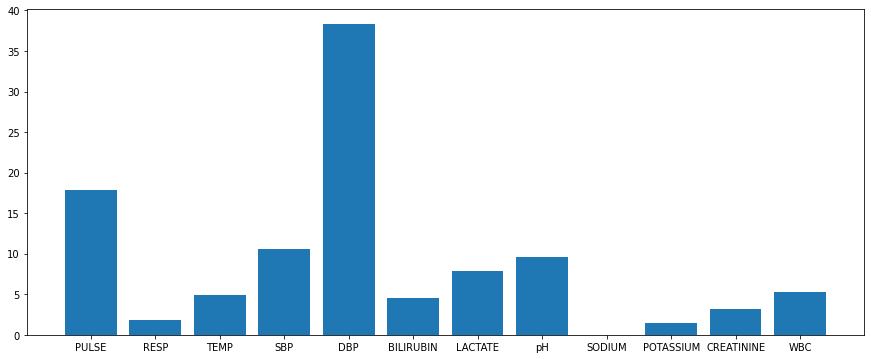

In [49]:
#Feature Importance 그려보기
plt.figure(figsize=(15,6))
plt.bar(train_results['XGB_0']['F_IMP'][0],train_results['XGB_0']['F_IMP'][1])

##간단한 NN모델 만들

In [50]:
import tensorflow as tf
# tf.config.list_physical_devices('GPU')

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(hidden_dims, output_dim):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_dims[0], activation='relu'),
    tf.keras.layers.Dense(hidden_dims[1], activation='relu'),
    tf.keras.layers.Dense(output_dim, activation='sigmoid') 
  ])
  return model

temp_model = build_model([50,20], 1)
temp_model.build(input_shape = (16,12))
temp_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (16, 50)                  650       
                                                                 
 dense_1 (Dense)             (16, 20)                  1020      
                                                                 
 dense_2 (Dense)             (16, 1)                   21        
                                                                 
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________


In [51]:
exp_id = 0

for t_idx, v_idx in kf.split(train_x):

  t_x = train_x[t_idx]
  t_y = train_y[t_idx]
  v_x = train_x[v_idx]
  v_y = train_y[v_idx]

  model = build_model(
    hidden_dims = [50, 20],
    output_dim = 1)

  # Early stop 정의 및 모델 체크포인트 정의
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

  # 모델 컴파일
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  # 모델 학습
  history = model.fit(t_x, t_y, epochs=5, callbacks=[es, mc], batch_size=16, validation_data=(v_x, v_y))
  valid_prob = model.predict(v_x)

  print('\n*******EXP_{} Results*******'.format(exp_id))
  roc = roc_auc_score(v_y, valid_prob)
  print('AUROC:',roc)
  prc = average_precision_score(v_y, valid_prob)
  print('AUPRC:', prc)
  print('\n')

  roc_x, roc_y, _ = roc_curve(v_y, valid_prob)
  prc_x, prc_y, _ = precision_recall_curve(v_y, valid_prob)

  train_results['NN_{}'.format(exp_id)] = {'Model': model, 'AUROC': roc, 'AUPRC': prc,
                                           'ROC': [roc_x, roc_y], 'PRC': [prc_x, prc_y]}
  exp_id += 1

Epoch 1/5
24/49 [=============>................] - ETA: 0s - loss: 0.4763 - acc: 0.8880 
Epoch 1: val_acc improved from -inf to 0.88601, saving model to best_model.h5
49/49 [==============================] - 2s 12ms/step - loss: 0.4314 - acc: 0.8782 - val_loss: 0.3394 - val_acc: 0.8860
Epoch 2/5
29/49 [================>.............] - ETA: 0s - loss: 0.3126 - acc: 0.9009
Epoch 2: val_acc did not improve from 0.88601
49/49 [==============================] - 0s 3ms/step - loss: 0.3314 - acc: 0.8886 - val_loss: 0.3267 - val_acc: 0.8860
Epoch 3/5
45/49 [==========================>...] - ETA: 0s - loss: 0.3247 - acc: 0.8861
Epoch 3: val_acc did not improve from 0.88601
49/49 [==============================] - 0s 3ms/step - loss: 0.3198 - acc: 0.8886 - val_loss: 0.3129 - val_acc: 0.8860
Epoch 4/5
45/49 [==========================>...] - ETA: 0s - loss: 0.3069 - acc: 0.8903
Epoch 4: val_acc did not improve from 0.88601
49/49 [==============================] - 0s 3ms/step - loss: 0.3097 - acc

##Hyperparameter Optimization 실습
###Grid Search
###Random Search
###Bayesian Optimization

XGBoost 모델을 이용하여 Scikit-learn에서 제공하는 다양한 Hyperparmeter Optimization 방법 실습

XGBoost의 주요 Parameter 들


*   eta [0, 1] : Step Size (learning rate)
*   gamma [0, ∞] : Minimum loss reduction
*   max_depth [0, ∞] : Maximum depth of tree
*   min_child_weight [0, ∞] : Minimum instance number of each node
*   max_delta_step [0, ∞] : Maximum delta step we allow each leaf output to be. 0: No Control





In [52]:
#Grid Search
%%time
from sklearn.model_selection import GridSearchCV
random_state = 220820
param_grid={'max_depth':  [3, 5],
            'eta': [0.01, 0.1],
            'gamma': [0, 1],
            'min_child_weight':  [1, 3],
            'max_delta_step':  [1,3],       
            'random_state': [random_state],
            'objective': ['binary:logistic']}

model = xgb.XGBClassifier()
kf = KFold(n_splits=5, shuffle=False, random_state=None)
gs=GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=True)

gs.fit(train_x, train_y)
gs_test_score=roc_auc_score(test_y, gs.predict(test_x))

print('TEST Score: ', gs_test_score)


print('===========================')
print("Best AUROC = {:.3f} , when params {}".format(gs.best_score_, gs.best_params_))
print('===========================')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
TEST Score:  0.7499569336778641
Best AUROC = 0.916 , when params {'eta': 0.01, 'gamma': 1, 'max_delta_step': 1, 'max_depth': 3, 'min_child_weight': 1, 'objective': 'binary:logistic', 'random_state': 220820}
CPU times: user 739 ms, sys: 399 ms, total: 1.14 s
Wall time: 12.5 s


In [53]:
#Random Search
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random

param_grid_random={'max_depth':  randint(2, 15),
            'eta': np.logspace(-5, 0, 100),
            'gamma': randint(0,5),
            'min_child_weight':  randint(1,10),
            'max_delta_step':  randint(1,10),       
            'random_state': [random_state],
            'objective': ['binary:logistic']}
model = xgb.XGBClassifier()
kf = KFold(n_splits=5, shuffle=False, random_state=None)
rs=RandomizedSearchCV(model, param_grid_random, n_iter = 10, scoring='roc_auc',
                n_jobs=-1, cv=kf, verbose=True, random_state=random_state)

rs.fit(train_x, train_y)
gs_test_score=roc_auc_score(test_y, gs.predict(test_x))

print('TEST Score: ', gs_test_score)


print('===========================')
print("Best AUROC = {:.3f} , when params {}".format(gs.best_score_, gs.best_params_))
print('===========================')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
TEST Score:  0.7499569336778641
Best AUROC = 0.916 , when params {'eta': 0.01, 'gamma': 1, 'max_delta_step': 1, 'max_depth': 3, 'min_child_weight': 1, 'objective': 'binary:logistic', 'random_state': 220820}
CPU times: user 259 ms, sys: 16.2 ms, total: 276 ms
Wall time: 3.1 s


In [61]:
import sklearn
print(sklearn.__version__)

1.0.2


In [65]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
from numpy.ma import MaskedArray
import sklearn.utils.fixes

sklearn.utils.fixes.MaskedArray = MaskedArray

import skopt

In [68]:
print(skopt.__version__)

0.8.1


In [71]:
#Bayesian Optimization
#! pip install scikit-optimize==0.8.1
#https://towardsdatascience.com/hyperparameter-optimization-with-scikit-learn-scikit-opt-and-keras-f13367f3e796
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space={'max_depth':  Integer(2, 15),
            'eta': np.logspace(-5, 0, 100),
            'gamma': Integer(0,5),
            'min_child_weight':  Integer(1,10),
            'max_delta_step':  Integer(1,10),       
            'random_state': [random_state],
            'objective': ['binary:logistic']}



model = xgb.XGBClassifier(eval_metric='auc')
kf = KFold(n_splits=5, shuffle=False, random_state=None)

bayes_search = BayesSearchCV(model, search_space, n_iter=10, # specify how many iterations
                                    scoring="roc_auc", n_jobs=-1, cv=kf)
bayes_search.fit(train_x, train_y)

bayes_test_score=roc_auc_score(test_y, bayes_search.predict(test_x))

print('===========================')
print("Best AUROC = {:.3f} , when params {}".format(bayes_search.best_score_, bayes_search.best_params_))
print('===========================')

TypeError: ignored

##결과를 그래프로 그려보기

In [72]:
train_results

{'LR_0': {'Model': LogisticRegression(),
  'AUROC': 0.7376395534290271,
  'AUPRC': 0.6352140459911243,
  'ROC': [array([0.        , 0.        , 0.        , 0.01754386, 0.01754386,
          0.35087719, 0.35087719, 0.36842105, 0.36842105, 0.62573099,
          0.62573099, 0.69005848, 0.69005848, 0.78362573, 0.78362573,
          0.78947368, 0.78947368, 0.87134503, 0.87134503, 0.90643275,
          0.90643275, 1.        ]),
   array([0.        , 0.04545455, 0.5       , 0.5       , 0.59090909,
          0.59090909, 0.68181818, 0.68181818, 0.72727273, 0.72727273,
          0.77272727, 0.77272727, 0.81818182, 0.81818182, 0.86363636,
          0.86363636, 0.90909091, 0.90909091, 0.95454545, 0.95454545,
          1.        , 1.        ])],
  'PRC': [array([0.12429379, 0.11931818, 0.12      , 0.12068966, 0.12138728,
          0.12209302, 0.12280702, 0.12352941, 0.1183432 , 0.11904762,
          0.11976048, 0.12048193, 0.12121212, 0.12195122, 0.12269939,
          0.12345679, 0.1242236 , 0.125 

In [73]:
#TestSet에 대해 결과 확인해보기
LR_model0 = train_results['LR_0']['Model']
test_prob = LR_model0.predict_proba(test_x)[:,1]

auroc = roc_auc_score(test_y, test_prob)
print('LR Test Result')
print('AUROC: ',auroc)
auprc = average_precision_score(test_y, test_prob)
print('AUPRC: ',auprc)

XGB_model0 = train_results['XGB_0']['Model']
test_prob = XGB_model0.predict_proba(test_x)[:,1]

print('\nXGB Test Result')
auroc = roc_auc_score(test_y, test_prob)
print('AUROC: ',auroc)
auprc = average_precision_score(test_y, test_prob)
print('AUPRC: ',auprc)

NN_model0 = train_results['NN_0']['Model']
test_prob = NN_model0.predict(test_x)

print('\nNN Test Result')
auroc = roc_auc_score(test_y, test_prob)
print('AUROC: ',auroc)
auprc = average_precision_score(test_y, test_prob)
print('AUPRC: ',auprc)

LR Test Result
AUROC:  0.6714900947459087
AUPRC:  0.474424338695124

XGB Test Result
AUROC:  0.8474590869939708
AUPRC:  0.6806700589307897
8/8 [==============================] - 0s 3ms/step

NN Test Result
AUROC:  0.6794142980189491
AUPRC:  0.4521389158955435


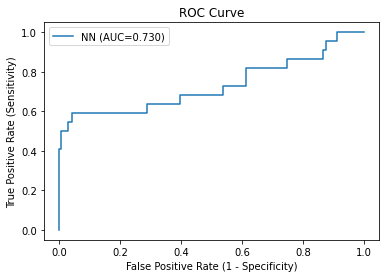

In [74]:
plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

x, y = train_results['NN_0']['ROC']
auc = train_results['NN_0']['AUROC']
plt.plot(x, y, linewidth=1.5, label='{} (AUC={:.3f})'.format('NN', auc))
plt.legend(fancybox=True)

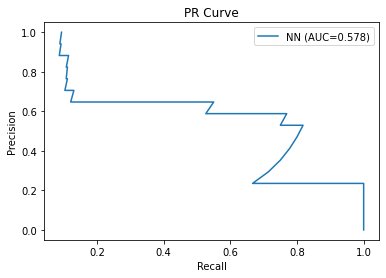

In [75]:
plt.figure()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')

x, y = train_results['NN_4']['PRC']
auc = train_results['NN_4']['AUPRC']
plt.plot(x, y, linewidth=1.5, label='{} (AUC={:.3f})'.format('NN', auc))
plt.legend(fancybox=True)

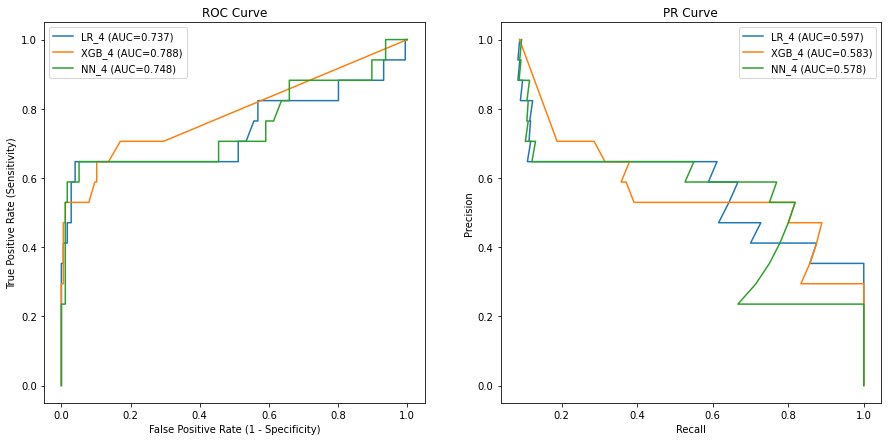

In [76]:
##Multi Plot
#여러 모델의 결과값을 하나의 그래프에 함께 그려보기
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_xlabel('False Positive Rate (1 - Specificity)')
ax1.set_ylabel('True Positive Rate (Sensitivity)')
ax1.set_title('ROC Curve')

for i,model in enumerate(['LR_4', 'XGB_4', 'NN_4']):
  color = 'C{}'.format(i)
  roc_x, roc_y = train_results[model]['ROC']
  auroc = train_results[model]['AUROC']
  ax1.plot(roc_x, roc_y, color=color, linewidth=1.5, label='{} (AUC={:.3f})'.format(model, auroc))

ax1.legend(fancybox=True)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curve')

for i,model in enumerate(['LR_4', 'XGB_4', 'NN_4']):
  color = 'C{}'.format(i)
  prc_x, prc_y = train_results[model]['PRC']
  auprc = train_results[model]['AUPRC']
  ax2.plot(prc_x, prc_y, color=color, linewidth=1.5, label='{} (AUC={:.3f})'.format(model, auprc))

ax2.legend(fancybox=True)

plt.show()